In [23]:
!pip install torch torchvision transformers

In [2]:
import os
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from transformers import ViTForImageClassification
from transformers import ViTFeatureExtractor
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from PIL import Image


In [6]:
from PIL import Image  # Add this import

class KidneyDataset(Dataset):
    def __init__(self, root_dir, feature_extractor):
        self.root_dir = root_dir
        self.feature_extractor = feature_extractor
        self.classes = ['Cyst', 'Normal', 'Stone', 'Tumor']
        self.data = []
        for idx, cls in enumerate(self.classes):
            path = os.path.join(root_dir, cls)
            for img in os.listdir(path):
                self.data.append((os.path.join(path, img), idx))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = Image.open(img_path).convert("RGB")  # Ensure RGB mode
        encoded_image = self.feature_extractor(images=image, return_tensors="pt")
        return encoded_image["pixel_values"].squeeze(0), label



root_dir = r'C:\Users\dheer\OneDrive\Documents\RIC\RESEARCH_PROJECT\archive\CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone\CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone'
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
dataset = KidneyDataset(root_dir, feature_extractor)
feature_extractor = ViTFeatureExtractor.from_pretrained(
    'google/vit-base-patch16-224-in21k',
    do_resize=True,
    size=224,
    do_normalize=True
)


# Split the dataset into train and test sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, pin_memory=True)



In [7]:
class ViTClassifier(nn.Module):
    def __init__(self, num_classes):
        super(ViTClassifier, self).__init__()
        self.vit = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k')
    
        self.vit.classifier = nn.Linear(self.vit.config.hidden_size, num_classes)

    def forward(self, x):
        x = self.vit(pixel_values=x).logits
        return x

model = ViTClassifier(num_classes=4)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model.to(device)


Using device: cpu


ViTClassifier(
  (vit): ViTForImageClassification(
    (vit): ViTModel(
      (embeddings): ViTEmbeddings(
        (patch_embeddings): ViTPatchEmbeddings(
          (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
        )
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (encoder): ViTEncoder(
        (layer): ModuleList(
          (0-11): 12 x ViTLayer(
            (attention): ViTSdpaAttention(
              (attention): ViTSdpaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
              (output): ViTSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
            )
        

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_recall_fscore_support


In [53]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=2e-5)


In [ ]:
train_losses = []
train_accuracies = []
num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    print(f'Epoch {epoch + 1}, Loss: {epoch_loss}, Accuracy: {epoch_acc}')


Epoch 1, Loss: 0.27686495688500223, Accuracy: 0.9271795901968662
Epoch 2, Loss: 0.030035431767375855, Accuracy: 0.997890719164323
Epoch 3, Loss: 0.012006991504008371, Accuracy: 1.0
Epoch 4, Loss: 0.006902135557302216, Accuracy: 1.0
Epoch 5, Loss: 0.0042959576495810985, Accuracy: 1.0
Epoch 6, Loss: 0.002789342693721406, Accuracy: 1.0
Epoch 7, Loss: 0.0018631393603014835, Accuracy: 1.0


In [9]:
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='macro')
print(f"Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1 Score: {f1}")
print(classification_report(all_labels, all_preds, target_names=['Cyst', 'Normal', 'Stone', 'Tumor']))

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
print(conf_matrix)


Accuracy: 0.7823293172690763
Precision: 0.7249081644571258
Recall: 0.6914297924077557
F1 Score: 0.702564371032486
              precision    recall  f1-score   support

        Cyst       0.85      0.90      0.88       731
      Normal       0.80      0.90      0.85      1006
       Stone       0.52      0.38      0.44       276
       Tumor       0.72      0.58      0.65       477

    accuracy                           0.78      2490
   macro avg       0.72      0.69      0.70      2490
weighted avg       0.77      0.78      0.77      2490

[[660   6  46  19]
 [ 10 905  27  64]
 [ 84  64 105  23]
 [ 19 157  23 278]]


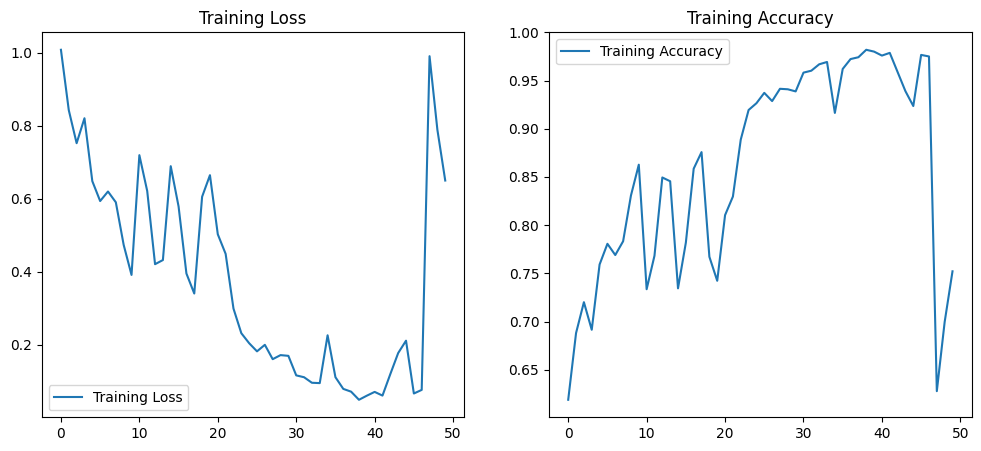

In [10]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.show()


In [11]:
df = pd.DataFrame({
    'Model': ['ViTClassifier'],
    'Accuracy': [accuracy],
    'Precision': [precision],
    'Recall': [recall],
    'F1 Score': [f1]
})
df.to_csv('model_performance.csv', index=False)


In [12]:
np.savetxt("confusion_matrix.csv", conf_matrix, delimiter=",", fmt='%d')


In [13]:
torch.save(model.state_dict(), 'vit_kidney_disease_classifier.pth')

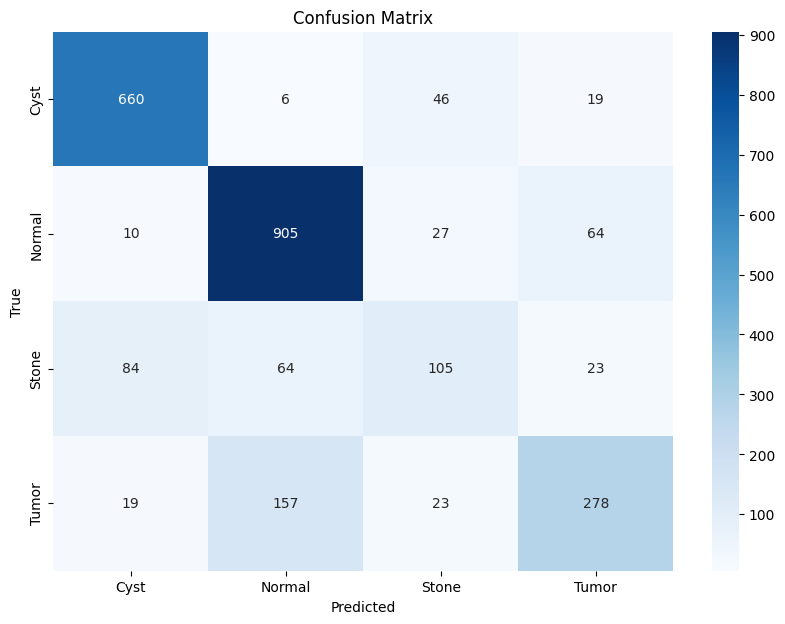

In [14]:
import seaborn as sns

# Assuming `conf_matrix` is your confusion matrix obtained from the evaluation step
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Cyst', 'Normal', 'Stone', 'Tumor'], yticklabels=['Cyst', 'Normal', 'Stone', 'Tumor'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.show()


In [15]:
model_path = '/kaggle/working/vit_kidney_disease_classifier.pth'
model.load_state_dict(torch.load(model_path))
model.eval()  # Set the model to evaluation mode


ViTClassifier(
  (vit): ViTForImageClassification(
    (vit): ViTModel(
      (embeddings): ViTEmbeddings(
        (patch_embeddings): ViTPatchEmbeddings(
          (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
        )
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (encoder): ViTEncoder(
        (layer): ModuleList(
          (0-11): 12 x ViTLayer(
            (attention): ViTAttention(
              (attention): ViTSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
              (output): ViTSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
            )
            (int

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate accuracy and other metrics if needed
accuracy = accuracy_score(all_labels, all_preds)
print(f'Accuracy: {accuracy}')

# Print the classification report
print(classification_report(all_labels, all_preds, target_names=['Cyst', 'Normal', 'Stone', 'Tumor']))


Accuracy: 0.7823293172690763
              precision    recall  f1-score   support

        Cyst       0.85      0.90      0.88       731
      Normal       0.80      0.90      0.85      1006
       Stone       0.52      0.38      0.44       276
       Tumor       0.72      0.58      0.65       477

    accuracy                           0.78      2490
   macro avg       0.72      0.69      0.70      2490
weighted avg       0.77      0.78      0.77      2490



Accuracy: 0.7823293172690763
Precision: 0.7249081644571258
Recall: 0.6914297924077557
F1 Score: 0.702564371032486


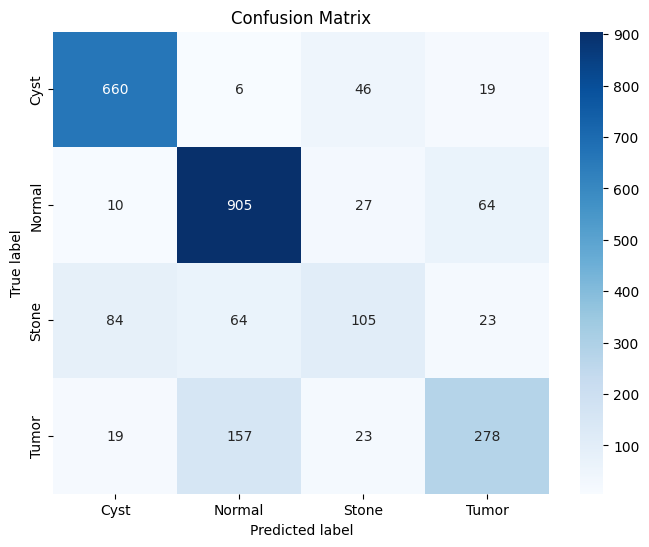

In [17]:
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate classification metrics
accuracy = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='macro')

# Print metrics to console
print(f'Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1 Score: {f1}')

# Create a DataFrame and save it to a CSV file
report_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Score': [accuracy, precision, recall, f1]
})
report_df.to_csv('/kaggle/working/classification_report.csv', index=False)

# Calculate and plot the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Cyst', 'Normal', 'Stone', 'Tumor'], yticklabels=['Cyst', 'Normal', 'Stone', 'Tumor'])
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig('/kaggle/working/confusion_matrix.png')
plt.show()


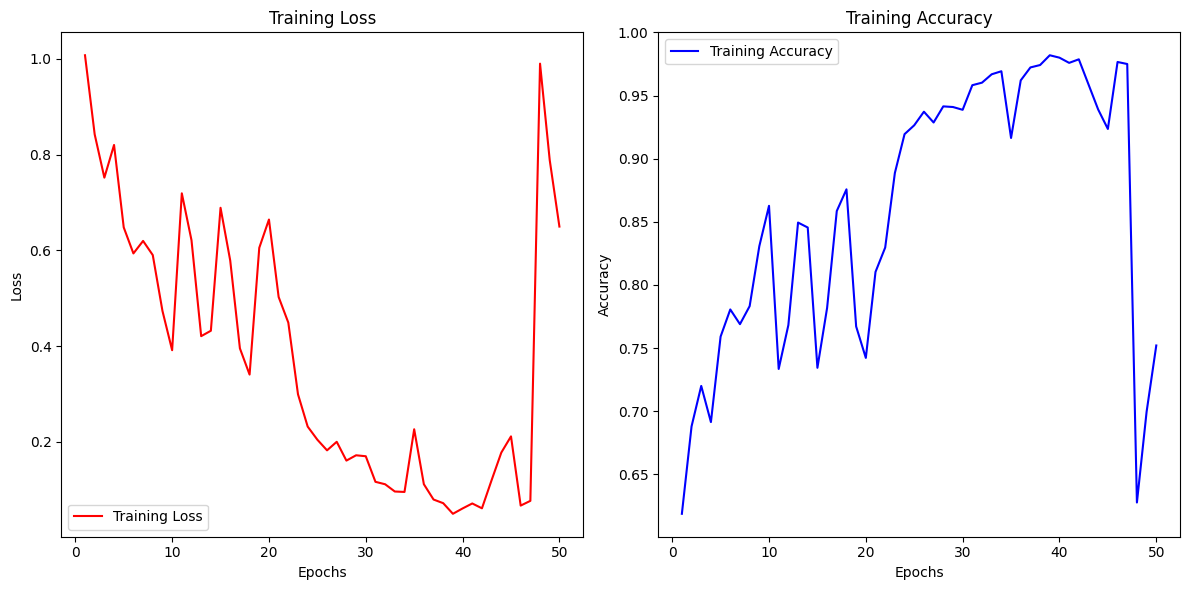

In [18]:
import matplotlib.pyplot as plt

# Assuming train_losses and train_accuracies contain loss and accuracy for each epoch
epochs = range(1, num_epochs + 1)

# Plotting training loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss', color='red')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting training accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy', color='blue')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig('training_loss_accuracy.png')
plt.show()


In [10]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Function

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = []

    def save_gradient(self, grad):
        self.gradients.append(grad)

    def forward(self, x):
        return self.model(x)

    def backward(self, target_class):
        self.model.zero_grad()
        target_class.backward(retain_graph=True)

    def generate_cam(self, input_image, target_class):
        # Forward pass
        self.model.eval()
        output = self.forward(input_image)

        # Backward pass
        self.backward(target_class)

        # Get the gradient and activations from the target layer
        gradients = self.gradients[0]
        activations = self.target_layer.output

        # Pool the gradients across the channels (Global Average Pooling)
        weights = torch.mean(gradients, dim=(2, 3), keepdim=True)

        # Weighted sum of activations
        cam = torch.sum(weights * activations, dim=1, keepdim=True)
        cam = torch.relu(cam)

        # Resize to the input image size
        cam = cam.squeeze().detach().cpu().numpy()
        cam = cv2.resize(cam, (input_image.shape[2], input_image.shape[3]))

        # Normalize the cam values
        cam = np.maximum(cam, 0)
        cam = cam / cam.max()

        return cam

    def overlay_cam(self, image, cam, alpha=0.5):
        # Convert the image from tensor to numpy array
        image = image.squeeze().permute(1, 2, 0).cpu().numpy()
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        # Apply the Grad-CAM heatmap to the original image
        heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
        overlay = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)

        return overlay

# Assuming you have a trained model (ViTClassifier) and an image loader (test_loader)
# Get a sample image and corresponding label from the dataset
image, label = next(iter(test_loader))

# Move the image and label to the device (GPU/CPU)
image = image.to(device)
label = label.to(device)

# Pass the image through the model to get predictions
output = model(image)

# Get the predicted class and target class index
_, predicted_class = torch.max(output, 1)

# Instantiate the Grad-CAM object
#target_layer = model.base.model.encoder.layer[-1].attention.self
#grad_cam = GradCAM(model, target_layer)

# Assuming you have a ViT model like ViTClassifier
# Access the last attention layer in the encoder block
target_layer = model.encoder.blocks[-1].attn

# Now, create the GradCAM object with this target layer
grad_cam = GradCAM(model, target_layer)

# Generate Grad-CAM for the image
grads = grad_cam.generate_gradcam(image)

# Generate Grad-CAM for the image
cam = grad_cam.generate_cam(image, output[0, predicted_class])

# Overlay the heatmap on the original image
overlay_image = grad_cam.overlay_cam(image, cam)

# Display the original image and the Grad-CAM overlay
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(image.squeeze().permute(1, 2, 0).cpu().numpy())
plt.title("Original Image")
plt.subplot(1, 2, 2)
plt.imshow(overlay_image)
plt.title("Grad-CAM Overlay")
plt.show()

# To visualize misclassified images:
# If the predicted class does not match the true label
if predicted_class != label:
    print(f"Misclassified! Predicted: {predicted_class}, True: {label}")


AttributeError: 'ViTClassifier' object has no attribute 'encoder'